In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd 
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from matplotlib import pyplot as plt

In [3]:
path = './drive/MyDrive/T-brain/2022'

# 信用卡交易
ccba = pd.read_csv(f'{path}/public_train_x_ccba_full_hashed.csv')

# 顧客消費資訊(日期、消費地國別、消費地幣別、金額)
cdtx = pd.read_csv(f'{path}/public_train_x_cdtx0001_full_hashed.csv')

# 顧客資訊
custinfo = pd.read_csv(f'{path}/public_train_x_custinfo_full_hashed.csv')

# 顧客交易資訊(交易日期、金額、匯率、交易代碼、分行代碼)
dp = pd.read_csv(f'{path}/public_train_x_dp_full_hashed.csv')

# 外匯交易
remit = pd.read_csv(f'{path}/public_train_x_remit1_full_hashed.csv')

# 警告資訊
alert_time = pd.read_csv(f'{path}/public_x_alert_date.csv')
#train_x_alert_date = pd.read_csv(f'{path}/train_x_alert_date.csv')

# 警告資訊與報SAR關係
y = pd.read_csv(f'{path}/train_y_answer.csv')

# 提交範例
doc = pd.read_csv(f'{path}/submit_sample.csv')

In [4]:
doc_merged = custinfo.merge(doc, on='alert_key', how='right').merge(alert_time, on='alert_key', how='left')
doc_merged = doc_merged[~doc_merged['cust_id'].isnull()]
max_doc = doc_merged.groupby('cust_id')['date'].max().reset_index()
max_doc.rename(columns={'date':'max_date'},inplace=True)
doc_merged = doc_merged.merge(max_doc, on='cust_id', how='left')
prev_list = doc_merged[doc_merged['max_date']>doc_merged['date']]['alert_key'].tolist()

In [5]:
alert_dp = dp[dp['cust_id'].isin(custinfo[custinfo['alert_key'].isin(alert_time['alert_key'].tolist())]['cust_id'].tolist())]
train_dp = dp[~dp['cust_id'].isin(custinfo[custinfo['alert_key'].isin(alert_time['alert_key'].tolist())]['cust_id'].tolist())]
train_dp['y'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
sar_idx = train_dp[train_dp['cust_id'].isin(custinfo[custinfo['alert_key'].isin(y[y['sar_flag']==1]['alert_key'].tolist())]['cust_id'].tolist())].index
train_dp.loc[sar_idx, 'y'] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [7]:
#Data Cleansing
#SAR戶僅留前X天
def sar_pred_d(x, day):
  prev_d = x.groupby('cust_id')['tx_date'].max() - day
  prev_d = prev_d.reset_index()
  prev_d.rename(columns={'tx_date':'prev_d'}, inplace=True)
  x = x.merge(prev_d, on='cust_id', how='left')
  x.drop(x[x['tx_date']<x['prev_d']].index,inplace=True)
  x.pop('prev_d')
  return x

train_dp = sar_pred_d(train_dp, 30)
alert_dp = sar_pred_d(alert_dp, 30)

In [8]:
#特徵前處理
def preprocess(data):
  dict1 = {}
  idx = 0
  num = 0
  for i in range(0,395,1):
    dict1[i] = str(idx)
    num += 1
    if num == 7:
      idx += 1
      num = 0
  data['tx_date_group'] = data.tx_date.map(lambda x: dict1[x])
  data['session_cust_id'] = data.tx_date_group + data.cust_id
  data['date_cust_id'] = data.tx_date.astype(str) + data.cust_id
  data['date_time_cust_id'] = data.tx_date.astype(str) + data.tx_date.astype(str) + data.cust_id
  return data

train_dp = preprocess(train_dp)
alert_dp = preprocess(alert_dp)

In [9]:
#session 交易差額比率
def amt_diff_func(data):
  session_amt_diff = data.groupby(['session_cust_id','debit_credit'])['tx_amt'].sum().reset_index()
  session_amt_diff = pd.pivot_table(session_amt_diff, index='session_cust_id', columns='debit_credit', values='tx_amt')
  session_amt_diff.fillna(1, inplace=True)
  session_amt_diff['session_amt_diff_ratio'] = \
    abs(session_amt_diff['CR'] - session_amt_diff['DB']) / abs(session_amt_diff['CR'] + session_amt_diff['DB'])
  session_amt_diff = session_amt_diff.reset_index()[['session_cust_id','session_amt_diff_ratio']]
  data = data.merge(session_amt_diff, on='session_cust_id', how='left')
#當日 交易差額比率
  date_amt_diff = data.groupby(['date_cust_id','debit_credit'])['tx_amt'].sum().reset_index()
  date_amt_diff = pd.pivot_table(date_amt_diff, index='date_cust_id', columns='debit_credit', values='tx_amt')
  date_amt_diff.fillna(1, inplace=True)
  date_amt_diff['date_amt_diff_ratio'] = \
  abs(date_amt_diff['CR'] - date_amt_diff['DB']) / abs(date_amt_diff['CR'] + date_amt_diff['DB'])
  date_amt_diff = date_amt_diff.reset_index()[['date_cust_id','date_amt_diff_ratio']]
  data = data.merge(date_amt_diff, on=['date_cust_id'], how='left')
#當時 交易差額比率
  date_time_amt_diff = data.groupby(['date_time_cust_id','debit_credit'])['tx_amt'].sum().reset_index()
  date_time_amt_diff = pd.pivot_table(date_time_amt_diff, index='date_time_cust_id', columns='debit_credit', values='tx_amt')
  date_time_amt_diff.fillna(1, inplace=True)
  date_time_amt_diff['date_time_amt_diff_ratio'] = \
  abs(date_time_amt_diff['CR'] - date_time_amt_diff['DB']) / abs(date_time_amt_diff['CR'] + date_time_amt_diff['DB'])
  date_time_amt_diff = date_time_amt_diff.reset_index()[['date_time_cust_id','date_time_amt_diff_ratio']]
  data = data.merge(date_time_amt_diff, on=['date_time_cust_id'], how='left')
  return data

train_dp = amt_diff_func(train_dp)
alert_dp = amt_diff_func(alert_dp)

In [10]:
def tx_cnt_branch_func(data):
#當時交易筆數 tx_cnt_date_time
  tx_cnt_date_time = data.groupby(['cust_id','tx_date','tx_time'])['debit_credit'].count().reset_index()
  tx_cnt_date_time.rename(columns={'debit_credit':'tx_cnt_date_time'}, inplace=True)
  data = data.merge(tx_cnt_date_time, on=['cust_id','tx_date','tx_time'], how='left')
#當日交易筆數 tx_cnt_date
  tx_cnt_date = data.groupby(['cust_id','tx_date'])['debit_credit'].count().reset_index()
  tx_cnt_date.rename(columns={'debit_credit':'tx_cnt_date'}, inplace=True)
  data = data.merge(tx_cnt_date, on=['cust_id','tx_date'], how='left')
#當session交易筆數 tx_cnt_session
  tx_cnt_session = data.groupby(['session_cust_id'])['debit_credit'].count().reset_index()
  tx_cnt_session.rename(columns={'debit_credit':'tx_cnt_session'}, inplace=True)
  data = data.merge(tx_cnt_session, on=['session_cust_id'], how='left')
#當時總分行數 txbranch_day_cnt
  txbranch_day_time_cnt = data.groupby(['cust_id','tx_date','tx_time'])['txbranch'].count().reset_index()
  txbranch_day_time_cnt.rename(columns={'txbranch':'txbranch_day_time_cnt'}, inplace=True)
  data = data.merge(txbranch_day_time_cnt, on=['cust_id','tx_date','tx_time'], how='left')
#單日總分行數 txbranch_day_cnt
  txbranch_day_cnt = data.groupby(['cust_id','tx_date'])['txbranch'].count().reset_index()
  txbranch_day_cnt.rename(columns={'txbranch':'txbranch_day_cnt'}, inplace=True)
  data = data.merge(txbranch_day_cnt, on=['cust_id','tx_date'], how='left')
#當session總分行數 txbranch_session_cnt
  txbranch_session_cnt = data.groupby(['session_cust_id'])['txbranch'].count().reset_index()
  txbranch_session_cnt.rename(columns={'txbranch':'txbranch_session_cnt'}, inplace=True)
  data = data.merge(txbranch_session_cnt, on=['session_cust_id'], how='left')
  return data
train_dp = tx_cnt_branch_func(train_dp)
alert_dp = tx_cnt_branch_func(alert_dp)

In [11]:
def atm_txn_func(data):
#當sessionATM 佔交易數比例
  session_atm_txn_ratio = data.groupby(['session_cust_id'])['ATM'].sum().reset_index()
  session_atm_txn_ratio.rename(columns={'ATM':'session_atm_txn_ratio'}, inplace=True)
  data = data.merge(session_atm_txn_ratio, on=['session_cust_id'], how='left')
  data.session_atm_txn_ratio = data.session_atm_txn_ratio / data.tx_cnt_date
#當日ATM 佔交易數比例
  day_atm_txn_ratio = data.groupby(['cust_id','tx_date'])['ATM'].sum().reset_index()
  day_atm_txn_ratio.rename(columns={'ATM':'day_atm_txn_ratio'}, inplace=True)
  data = data.merge(day_atm_txn_ratio, on=['cust_id','tx_date'], how='left')
  data.day_atm_txn_ratio = data.day_atm_txn_ratio / data.tx_cnt_date
#當時ATM 佔交易數比例
  day_time_atm_txn_ratio = data.groupby(['cust_id','tx_date','tx_time'])['ATM'].sum().reset_index()
  day_time_atm_txn_ratio.rename(columns={'ATM':'day_time_atm_txn_ratio'}, inplace=True)
  data = data.merge(day_time_atm_txn_ratio, on=['cust_id','tx_date','tx_time'], how='left')
  data.day_time_atm_txn_ratio = data.day_time_atm_txn_ratio / data.tx_cnt_date_time
  return data
train_dp = atm_txn_func(train_dp)
alert_dp = atm_txn_func(alert_dp)

In [12]:
def cross_bank_func(data):
  #當session跨行 佔交易數比例
  session_cross_bank_ratio = data.groupby(['session_cust_id'])['cross_bank'].sum().reset_index()
  session_cross_bank_ratio.rename(columns={'cross_bank':'session_cross_bank_ratio'}, inplace=True)
  data = data.merge(session_cross_bank_ratio, on=['session_cust_id'], how='left')
  data.session_cross_bank_ratio = data.session_cross_bank_ratio / data.tx_cnt_date
  #當日跨行 佔交易數比例
  day_cross_bank_ratio = data.groupby(['cust_id','tx_date'])['cross_bank'].sum().reset_index()
  day_cross_bank_ratio.rename(columns={'cross_bank':'day_cross_bank_ratio'}, inplace=True)
  data = data.merge(day_cross_bank_ratio, on=['cust_id','tx_date'], how='left')
  data.day_cross_bank_ratio = data.day_cross_bank_ratio / data.tx_cnt_date
  #當時跨行 佔交易數比例
  day_time_cross_bank_ratio = data.groupby(['cust_id','tx_date','tx_time'])['cross_bank'].sum().reset_index()
  day_time_cross_bank_ratio.rename(columns={'cross_bank':'day_time_cross_bank_ratio'}, inplace=True)
  data = data.merge(day_time_cross_bank_ratio, on=['cust_id','tx_date','tx_time'], how='left')
  data.day_time_cross_bank_ratio = data.day_time_cross_bank_ratio / data.tx_cnt_date_time
  return data
train_dp = cross_bank_func(train_dp)
alert_dp = cross_bank_func(alert_dp)

In [13]:
cdtx.columns

Index(['cust_id', 'date', 'country', 'cur_type', 'amt'], dtype='object')

In [14]:
def trytry(data):
  # 
  d = cdtx.groupby(['cust_id','date']).size().reset_index(name='cnt')
  bins = [-np.inf, 50, 100, 150, 200, np.inf]
  labels = [x for x in range(len(bins)-1)]
  d['cust_id_date_cnt'] = pd.cut(d.cnt, bins=bins, labels=labels).astype('int')
  d['rolling_sum_2'] = d.groupby(['cust_id'])['cnt'].rolling(2).sum().reset_index(level=0, drop=True)
  d['rolling_sum_4'] = d.groupby(['cust_id'])['cnt'].rolling(4).sum().reset_index(level=0, drop=True)
  d['rolling_sum_6'] = d.groupby(['cust_id'])['cnt'].rolling(6).sum().reset_index(level=0, drop=True)
  d.rename(columns = {'date':'tx_date'}, inplace = True)
  data = data.merge(d, on=['cust_id', 'tx_date'], how='left')

  # country + cur_type
  d = cdtx.copy()
  d['mix_country_cur_type'] = d['country']*100 + d['cur_type']
  d.rename(columns = {'date':'tx_date'}, inplace = True)
  d = d[['cust_id','tx_date','mix_country_cur_type']]
  data = data.merge(d, on=['cust_id', 'tx_date'], how='left')

  # 
  d = cdtx.copy()
  bins = [-np.inf, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 10000, np.inf]
  labels = [x for x in range(len(bins)-1)]
  d['amt_group'] = pd.cut(d.amt, bins=bins, labels=labels).astype('int')
  d.rename(columns = {'date':'tx_date'}, inplace = True)
  d = d[['cust_id','tx_date','amt_group']]
  data = data.merge(d, on=['cust_id', 'tx_date'], how='left')

  return data

train_dp_ = trytry(train_dp)
alert_dp_ = trytry(alert_dp)

In [15]:
train_dp_.columns

Index(['cust_id', 'debit_credit', 'tx_date', 'tx_time', 'tx_type', 'tx_amt',
       'exchg_rate', 'info_asset_code', 'fiscTxId', 'txbranch', 'cross_bank',
       'ATM', 'y', 'tx_date_group', 'session_cust_id', 'date_cust_id',
       'date_time_cust_id', 'session_amt_diff_ratio', 'date_amt_diff_ratio',
       'date_time_amt_diff_ratio', 'tx_cnt_date_time', 'tx_cnt_date',
       'tx_cnt_session', 'txbranch_day_time_cnt', 'txbranch_day_cnt',
       'txbranch_session_cnt', 'session_atm_txn_ratio', 'day_atm_txn_ratio',
       'day_time_atm_txn_ratio', 'session_cross_bank_ratio',
       'day_cross_bank_ratio', 'day_time_cross_bank_ratio', 'cnt',
       'cust_id_date_cnt', 'rolling_sum_2', 'rolling_sum_4', 'rolling_sum_6',
       'mix_country_cur_type', 'amt_group'],
      dtype='object')

In [16]:
train_col = ['cust_id','tx_date','tx_time','session_amt_diff_ratio', 'date_amt_diff_ratio',
       'date_time_amt_diff_ratio', 'tx_cnt_date_time', 'tx_cnt_date',
       'txbranch_day_time_cnt', 'txbranch_day_cnt', 'day_atm_txn_ratio',
       'day_time_atm_txn_ratio','day_cross_bank_ratio','day_time_cross_bank_ratio',
       'cust_id_date_cnt','rolling_sum_4','rolling_sum_2','rolling_sum_6','mix_country_cur_type','amt_group',
       #'tx_cnt_session','txbranch_session_cnt','session_atm_txn_ratio','session_cross_bank_ratio',
       'y']
x_col = train_col[3:-1]
train_data = train_dp_[train_col]
#train_data

In [17]:
Y = train_data['y']
X = train_data[x_col]

In [18]:
#model training 1
#逐筆交易處理
test_size = 0.2
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
#previous 30days label of 1
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(precision_score(y_test, predictions))
print(recall_score(y_test, predictions))

# Accuracy: 92.17%
# 0.9980544747081712
# 0.5003657644476956

Accuracy: 99.45%
0.9998000095380066
0.9938965456069198


<BarContainer object of 17 artists>

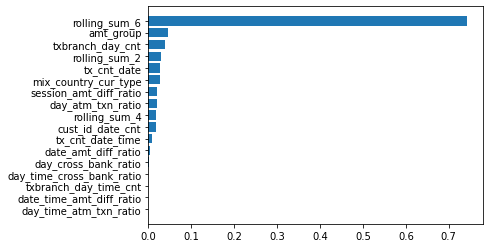

In [19]:
# feature importance
sorted_idx = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])